   Infected  Susceptible  Total
0         2           78     80
1         3           77     80
2         5           75     80
3         7           73     80
4        12           68     80


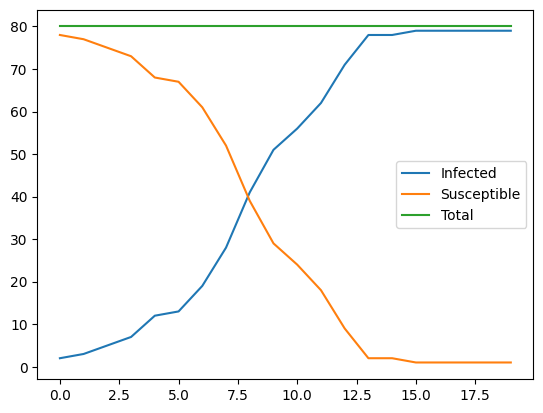

final:     Infected  Susceptible  Total
19        79            1     80


In [ ]:
import sys, os
sys.path.append(os.path.abspath(".."))

from src.model import InfectionModel
import matplotlib.pyplot as plt

# single run tuned for visible spread with separated radii
model = InfectionModel(
    num_people=80, width=50, height=50,
    speed=3.0,
    collision_radius=1.0,   # bounce only (small)
    contact_radius=6.0,     # infection proximity (large)
    frame_infection_prob=0.5,
    initial_infected=2,
    seed=42
)

for _ in range(100):
    if not model.running:
        break
    model.step()

results = model.datacollector.get_model_vars_dataframe()
print(results.head())
results.plot(y=["Infected", "Susceptible", "Total"])
plt.show()
print("final:", results.tail(1))


In [5]:
import sys, os, pandas as pd, matplotlib.pyplot as plt
sys.path.append(os.path.abspath(".."))
from src.model import InfectionModel

def run_case(name: str, **kwargs) -> pd.DataFrame:
    """Run one scenario and return time series."""
    m = InfectionModel(**kwargs)
    steps = 0
    while m.running and steps < 5000:
        m.step()
        steps += 1
    df = m.datacollector.get_model_vars_dataframe().reset_index().rename(columns={"index": "Step"})
    df["Scenario"] = name
    return df

def plot_curves(df: pd.DataFrame, out_dir: str, prefix: str) -> None:
    """Save infected/susceptible curves for all scenarios."""
    out = os.path.join("..", out_dir)
    os.makedirs(out, exist_ok=True)

    p1 = df.pivot_table(index="Step", columns="Scenario", values="Infected", aggfunc="last")
    ax = p1.plot(figsize=(7,4))
    ax.set_title("Infected vs Time"); ax.set_xlabel("Step"); ax.set_ylabel("Infected")
    fig = ax.get_figure(); fig.tight_layout(); fig.savefig(os.path.join(out, f"{prefix}_infected.png"), dpi=160)
    plt.show(); plt.close(fig)

    p2 = df.pivot_table(index="Step", columns="Scenario", values="Susceptible", aggfunc="last")
    ax = p2.plot(figsize=(7,4))
    ax.set_title("Susceptible vs Time"); ax.set_xlabel("Step"); ax.set_ylabel("Susceptible")
    fig = ax.get_figure(); fig.tight_layout(); fig.savefig(os.path.join(out, f"{prefix}_susceptible.png"), dpi=160)
    plt.show(); plt.close(fig)


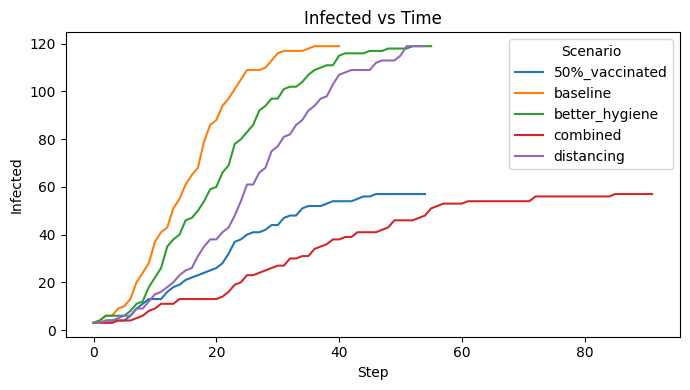

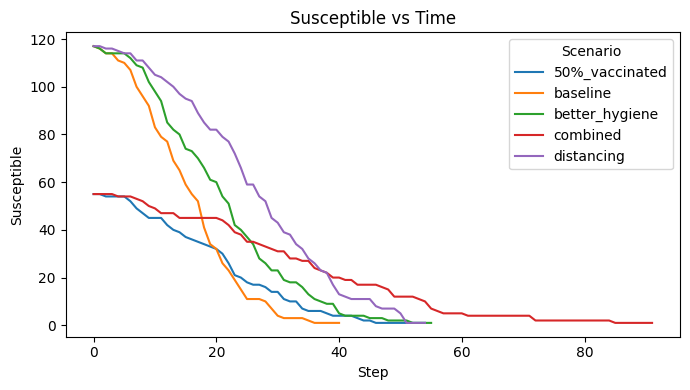

,Scenario,Infected,Susceptible
40,baseline,119,1
95,distancing,119,1
206,better_hygiene,119,1
150,50%_vaccinated,57,1
298,combined,57,1


In [ ]:
from pathlib import Path

OUT_DIR = "outputs"

base = dict(
    num_people=120, width=100, height=100,
    speed=3.0,
    collision_radius=1.0,   # bounce only
    contact_radius=6.0,     # infection proximity
    frame_infection_prob=0.35, initial_infected=3,
    vaccinated_rate=0.0, vaccinated_effect=0.5,
    hygiene_factor=1.0, distancing_factor=1.0,
    seed=42,
)

scenarios = {
    "baseline": {**base},
    "distancing": {**base, "distancing_factor": 0.6},
    "50%_vaccinated": {**base, "vaccinated_rate": 0.5},
    "better_hygiene": {**base, "hygiene_factor": 0.7},
    "combined": {**base, "vaccinated_rate": 0.5, "distancing_factor": 0.7},
}

frames = []
Path(os.path.join("..", OUT_DIR)).mkdir(exist_ok=True)

for name, params in scenarios.items():
    df = run_case(name, **params)
    df.to_csv(os.path.join("..", OUT_DIR, f"{name}.csv"), index=False)
    frames.append(df)

all_df = pd.concat(frames, ignore_index=True)
all_df.to_csv(os.path.join("..", OUT_DIR, "all_scenarios.csv"), index=False)

plot_curves(all_df, OUT_DIR, "all_scenarios")

# Final snapshot (last row per scenario)
final = all_df.sort_values("Step").groupby("Scenario").tail(1)[["Scenario","Infected","Susceptible"]]
final.sort_values("Infected", ascending=False)
